In [1]:
# %pip install graphviz
# %pip install pydotplus
# %pip install heamy
# %pip install mlxtend
# %pip install git+git://github.com/kvoyager/GmdhPy.git

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.core.display import HTML
from sklearn.tree import export_text
# from operator import itemgetter
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from IPython.display import Image
import graphviz
import pydotplus
from io import StringIO
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset
from mlxtend.classifier import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from gmdhpy import gmdh

In [3]:
# # Визуализация дерева
# def get_png_tree(tree_model_param, feature_names_param):
#     dot_data = StringIO()
#     export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
#                     filled=True, rounded=True, special_characters=True)
#     graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#     return graph.create_png()

In [4]:
dataset = pd.read_csv('milknew.csv')

In [5]:
# Первые 5 строк датасета
dataset.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [6]:
# Размер датасета - 1059 строк, 8 колонок
dataset.shape

(1059, 8)

In [7]:
dataset.dtypes

pH            float64
Temprature      int64
Taste           int64
Odor            int64
Fat             int64
Turbidity       int64
Colour          int64
Grade          object
dtype: object

In [8]:
# Проверим наличие пустых значений
# Цикл по колонкам датасета
for col in dataset.columns:
    # Количество пустых значений - все значения заполнены
    temp_null_count = dataset[dataset[col].isnull()].shape[0]
    print('{} - {}'.format(col, temp_null_count))

pH - 0
Temprature - 0
Taste - 0
Odor - 0
Fat  - 0
Turbidity - 0
Colour - 0
Grade - 0


In [9]:
# Основные статистические характеристки набора данных
dataset.describe()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000


In [10]:
copied_ds = dataset.copy()

for col in dataset.select_dtypes(include=['object']).columns:
    copied_ds[col] = copied_ds[col].astype('string')
dataset = copied_ds

In [11]:
milk_x_ds = pd.DataFrame(data=dataset, columns=['pH', 'Temprature', 'Taste', 'Odor', 'Turbidity', 'Colour'])
milk_x_ds

,pH,Temprature,Taste,Odor,Turbidity,Colour
0,6.6,35,1,0,0,254
1,6.6,36,0,1,1,253
2,8.5,70,1,1,1,246
3,9.5,34,1,1,1,255
4,6.6,37,0,0,0,255
...,...,...,...,...,...,...
1054,6.7,45,1,1,0,247
1055,6.7,38,1,0,0,255
1056,3.0,40,1,1,1,255
1057,6.8,43,1,0,0,250


In [12]:
milk_y_ds = pd.DataFrame(data=dataset, columns=['Grade'])
milk_y_ds

,Grade
0,high
1,high
2,low
3,low
4,medium
...,...
1054,medium
1055,high
1056,low
1057,high


In [13]:
y = dataset.iloc[:, -1].values
y

<StringArray>
[  'high',   'high',    'low',    'low', 'medium',   'high',    'low',
    'low',    'low', 'medium',
 ...
 'medium',   'high',    'low', 'medium',    'low', 'medium',   'high',
    'low',   'high',    'low']
Length: 1059, dtype: string

In [14]:
milk_ds = pd.DataFrame(data=dataset, columns=['pH', 'Temprature', 'Taste', 'Odor', 'Turbidity', 'Colour', 'Grade'])
milk_ds

,pH,Temprature,Taste,Odor,Turbidity,Colour,Grade
0,6.6,35,1,0,0,254,high
1,6.6,36,0,1,1,253,high
2,8.5,70,1,1,1,246,low
3,9.5,34,1,1,1,255,low
4,6.6,37,0,0,0,255,medium
...,...,...,...,...,...,...,...
1054,6.7,45,1,1,0,247,medium
1055,6.7,38,1,0,0,255,high
1056,3.0,40,1,1,1,255,low
1057,6.8,43,1,0,0,250,high


In [15]:
# Обучим классификатор на 5 деревьях
bc1 = BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)
bc1.fit(milk_x_ds, y)

C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\ensemble\_bagging.py:707: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)

In [16]:
tree_rules = export_text(bc1[0], feature_names=list(milk_x_ds.columns))
HTML('<pre>' + tree_rules + '</pre>')

In [17]:
tree_rules = export_text(bc1[1], feature_names=list(milk_x_ds.columns))
HTML('<pre>' + tree_rules + '</pre>')

In [18]:
tree_rules = export_text(bc1[2], feature_names=list(milk_x_ds.columns))
HTML('<pre>' + tree_rules + '</pre>')

In [19]:
# Какие объекты были использованы в обучающей выборке каждого дерева
bc1.estimators_samples_

[array([910, 138, 766, ..., 387, 881,  66]),
 array([814, 482, 861, ..., 750, 335,  65]),
 array([ 643,  332, 1022, ...,  894,  426,  540]),
 array([916, 598, 990, ..., 609,  63, 663]),
 array([656, 741, 201, ..., 288, 156, 636])]

In [20]:
# Сконвертируем эти данные в двоичную матрицу, 
# 1 соответствует элементам, попавшим в обучающую выборку
bin_array = np.zeros((5, milk_x_ds.shape[0]))
for i in range(5):
    for j in bc1.estimators_samples_[i]:
        bin_array[i][j] = 1
bin_array

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 1., 1.]])

In [21]:
# Оценим Out-of-bag error, теоретическое значение 37%
for i in range(5):
    cur_data = bin_array[i]
    len_cur_data = len(cur_data)
    sum_cur_data = sum(cur_data)
    (len(bin_array[0]) - sum(bin_array[0])) / len(bin_array[0])
    oob_i = (len_cur_data - sum_cur_data) / len_cur_data
    print('Для модели № {} размер OOB составляет {}%'.format(i+1, round(oob_i, 4)*100.0))

Для модели № 1 размер OOB составляет 35.980000000000004%
Для модели № 2 размер OOB составляет 35.69%
Для модели № 3 размер OOB составляет 37.11%
Для модели № 4 размер OOB составляет 37.96%
Для модели № 5 размер OOB составляет 36.919999999999995%


In [22]:
# Out-of-bag error, возвращаемый классификатором
# Для классификации используется метрика accuracy
bc1.oob_score_, 1-bc1.oob_score_

(0.9131255901794145, 0.08687440982058547)

In [23]:
# Параметр oob_decision_function_ возвращает вероятности 
# принадлежности объекта к классам на основе oob
# В данном примере три класса, 
# значения nan могут возвращаться в случае маленькой выборки
bc1.oob_decision_function_[55:70]

array([[nan, nan, nan],
       [nan, nan, nan],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [nan, nan, nan],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [nan, nan, nan],
       [ 0.,  1.,  0.]])

In [24]:
# Визуализация обученных решающих деревьев
# Image(get_png_tree(bc1.estimators_[0], milk_x_ds.columns), width='80%')

In [25]:
###############
###############
###############
###############
###############

In [26]:
# Обучим классификатор на 5 деревьях
tree1 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)
tree1.fit(milk_x_ds, y)

C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\ensemble\_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)

In [27]:
tree_rules2 = export_text(tree1[0], feature_names=list(milk_x_ds.columns))
HTML('<pre>' + tree_rules2 + '</pre>')

In [28]:
tree_rules2 = export_text(tree1[1], feature_names=list(milk_x_ds.columns))
HTML('<pre>' + tree_rules2 + '</pre>')

In [29]:
# Out-of-bag error, возвращаемый классификатором
tree1.oob_score_, 1-tree1.oob_score_

(0.9140698772426817, 0.08593012275731826)

In [30]:
###############
###############
###############
###############
###############

In [31]:
X = dataset.iloc[:, :-1].values
X

array([[  6.6,  35. ,   1. , ...,   1. ,   0. , 254. ],
       [  6.6,  36. ,   0. , ...,   0. ,   1. , 253. ],
       [  8.5,  70. ,   1. , ...,   1. ,   1. , 246. ],
       ...,
       [  3. ,  40. ,   1. , ...,   1. ,   1. , 255. ],
       [  6.8,  43. ,   1. , ...,   1. ,   0. , 250. ],
       [  8.6,  55. ,   0. , ...,   1. ,   1. , 255. ]])

In [32]:
milk_X_train, milk_X_test, milk_y_train, milk_y_test = train_test_split(
    X, 
    milk_ds['Grade'], test_size=0.1, random_state=1)

In [33]:
y = dataset.iloc[:, -1].values
y

<StringArray>
[  'high',   'high',    'low',    'low', 'medium',   'high',    'low',
    'low',    'low', 'medium',
 ...
 'medium',   'high',    'low', 'medium',    'low', 'medium',   'high',
    'low',   'high',    'low']
Length: 1059, dtype: string

In [34]:
BagModel = BaggingClassifier(n_estimators=5, oob_score=True, random_state=1)

In [35]:
BagModel.fit(milk_X_train, milk_y_train)

C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\ensemble\_bagging.py:707: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


BaggingClassifier(n_estimators=5, oob_score=True, random_state=1)

In [36]:
y_bag_predict = BagModel.predict(milk_X_test)

In [37]:
y_bag_predict

array(['medium', 'low', 'high', 'low', 'high', 'medium', 'low', 'low',
       'high', 'low', 'high', 'medium', 'high', 'medium', 'high',
       'medium', 'medium', 'high', 'low', 'low', 'medium', 'medium',
       'high', 'low', 'medium', 'medium', 'medium', 'medium', 'low',
       'medium', 'low', 'low', 'high', 'low', 'high', 'high', 'high',
       'medium', 'medium', 'low', 'high', 'low', 'medium', 'medium',
       'high', 'medium', 'low', 'medium', 'medium', 'high', 'low', 'high',
       'medium', 'low', 'low', 'low', 'medium', 'low', 'high', 'high',
       'medium', 'low', 'low', 'medium', 'low', 'high', 'low', 'medium',
       'low', 'medium', 'low', 'high', 'low', 'low', 'high', 'medium',
       'high', 'low', 'high', 'low', 'medium', 'low', 'medium', 'low',
       'low', 'low', 'medium', 'low', 'medium', 'low', 'medium', 'medium',
       'high', 'high', 'high', 'low', 'low', 'low', 'low', 'medium',
       'low', 'medium', 'low', 'medium', 'medium', 'low'], dtype=object)

In [38]:
accuracy_score(milk_y_test, y_bag_predict)

1.0

In [39]:
recall_score(milk_y_test, y_bag_predict, average=None)

array([1., 1., 1.])

In [40]:
BagModel.oob_score_

0.9233997901364114

In [41]:
###############
###############
###############
###############
###############

In [42]:
# Обучим классификатор на 5 деревьях
ab1 = AdaBoostClassifier(n_estimators=5, algorithm='SAMME', random_state=10)
ab1.fit(milk_X_train, milk_y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=5, random_state=10)

In [43]:
y_boost_predict = ab1.predict(milk_X_test)

In [44]:
accuracy_score(milk_y_test, y_boost_predict)

0.4811320754716981

In [45]:
recall_score(milk_y_test, y_boost_predict, average=None)

array([0.       , 0.3255814, 1.       ])

In [46]:
precision_score(milk_y_test, y_boost_predict, average=None)

array([0.        , 1.        , 0.42528736])

C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (1059).

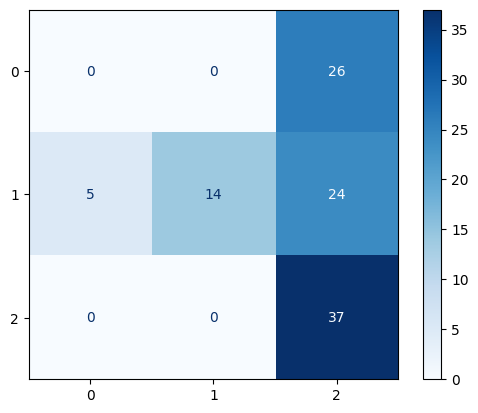

In [47]:
plot_confusion_matrix(ab1, milk_X_test, milk_y_test, 
                      display_labels=milk_ds['Grade'].values, 
                      cmap=plt.cm.Blues, normalize=None)

In [48]:
###############
###############
###############
###############
###############

In [49]:
le = LabelEncoder()
milk_y_ds_le = le.fit_transform(milk_ds['Grade'])
milk_y_ds_le

array([0, 0, 1, ..., 1, 0, 1])

In [50]:
milk_X_train2, milk_X_test2, milk_y_train2, milk_y_test2 = train_test_split(
    X, 
    milk_y_ds_le, test_size=0.1, random_state=1)

In [51]:
# Эксперимент 1
# Первый уровень - две модели: дерево и логистическая регрессия
# Второй уровень: логистическая регрессия
clf1 = DecisionTreeClassifier(random_state=1)
clf2 = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier = clf2)

In [52]:
# for clf, label in zip([clf1, clf2, sclf], ['Tree', 'Logistic', 'Stacking']):
#     scores = cross_val_score(clf, X, milk_y_ds_le, cv=3, scoring = 'f1_macro')
#     print("F1 scores: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [53]:
for clf, label in zip([clf1, clf2, sclf], ['Tree', 'Logistic', 'Stacking']):
    clf.fit(milk_X_train2, milk_y_train2)
    y_stack_predict = clf.predict(milk_X_test2)
#     accuracy_score(milk_y_test2, y_stack_predict)
#     scores = cross_val_score(clf, X, milk_y_ds_le, cv=3, scoring = 'f1_macro')
#     print("F1 scores: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    print("Accuracy score: %0.2f [%s]" % (accuracy_score(milk_y_test2, y_stack_predict), label))

Accuracy score: 1.00 [Tree]
Accuracy score: 0.72 [Logistic]
Accuracy score: 1.00 [Stacking]


C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

In [54]:
# Эксперимент 2
# Первый уровень - две модели: дерево и логистическая регрессия
# Второй уровень: случайный лес
clf1 = DecisionTreeClassifier(random_state=1)
clf2 = LogisticRegression()
clf3 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)
sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier = clf3)

In [55]:
for clf, label in zip([clf1, clf2, sclf], ['Tree', 'Logistic', 'Stacking']):
    clf.fit(milk_X_train2, milk_y_train2)
    y_stack_predict = clf.predict(milk_X_test2)
#     accuracy_score(milk_y_test2, y_stack_predict)
#     scores = cross_val_score(clf, X, milk_y_ds_le, cv=3, scoring = 'f1_macro')
#     print("F1 scores: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    print("Accuracy score: %0.2f [%s]" % (accuracy_score(milk_y_test2, y_stack_predict), label))

Accuracy score: 1.00 [Tree]
Accuracy score: 0.72 [Logistic]
Accuracy score: 1.00 [Stacking]


C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

In [56]:
# Эксперимент 3
# Первый уровень - две модели: логистическая регрессия и случайный лес
# Второй уровень: случайный лес
# clf1 = DecisionTreeClassifier(random_state=1)
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=13)
sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier = clf2)

In [57]:
for clf, label in zip([clf1, clf2, sclf], ['Logistic', 'Forest', 'Stacking']):
    clf.fit(milk_X_train2, milk_y_train2)
    y_stack_predict = clf.predict(milk_X_test2)
#     accuracy_score(milk_y_test2, y_stack_predict)
#     scores = cross_val_score(clf, X, milk_y_ds_le, cv=3, scoring = 'f1_macro')
#     print("F1 scores: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    print("Accuracy score: %0.2f [%s]" % (accuracy_score(milk_y_test2, y_stack_predict), label))
#     print("F1 scores: %0.2f [%s]" % (f1_score(milk_y_test2, y_stack_predict, average = None), label))

Accuracy score: 0.72 [Logistic]
Accuracy score: 1.00 [Forest]
Accuracy score: 1.00 [Stacking]


C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\ensemble\_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
C:\PycharmProjects\OAD_NIRS\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (ma

In [58]:
###############
###############
###############
###############
###############

In [59]:
n_clf = MLPClassifier(random_state=1, max_iter=300).fit(milk_X_train2, milk_y_train2)

In [60]:
n_clf.predict_proba(milk_X_test2[:1])

array([[0.37284555, 0.17843762, 0.44871683]])

In [61]:
y_neuro_predict = n_clf.predict(milk_X_test2)
y_neuro_predict

array([2, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 1, 1, 2, 2,
       0, 1, 2, 2, 2, 2, 0, 2, 1, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 2, 1, 2, 2, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2,
       1, 2, 1, 0, 1, 1, 1, 1, 2, 2, 0, 1, 1, 0, 2, 1, 2, 1, 0, 1, 2, 1,
       2, 1, 2, 2, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1])

In [62]:
n_clf.score(milk_X_test2, milk_y_test2)

0.8113207547169812

In [63]:
accuracy_score(milk_y_test2, y_neuro_predict)

0.8113207547169812

In [64]:
###############
###############
###############
###############
###############

In [65]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [66]:
model = gmdh.Classifier()

In [67]:
bin_milk_y = convert_target_to_binary(dataset['Grade'], 'high')

In [68]:
milk_ds_gmdh = milk_ds
milk_ds_gmdh

,pH,Temprature,Taste,Odor,Turbidity,Colour,Grade
0,6.6,35,1,0,0,254,high
1,6.6,36,0,1,1,253,high
2,8.5,70,1,1,1,246,low
3,9.5,34,1,1,1,255,low
4,6.6,37,0,0,0,255,medium
...,...,...,...,...,...,...,...
1054,6.7,45,1,1,0,247,medium
1055,6.7,38,1,0,0,255,high
1056,3.0,40,1,1,1,255,low
1057,6.8,43,1,0,0,250,high


In [69]:
milk_ds_gmdh['target_bin'] = bin_milk_y
milk_ds_gmdh.head()

,pH,Temprature,Taste,Odor,Turbidity,Colour,Grade,target_bin
0,6.6,35,1,0,0,254,high,1
1,6.6,36,0,1,1,253,high,1
2,8.5,70,1,1,1,246,low,0
3,9.5,34,1,1,1,255,low,0
4,6.6,37,0,0,0,255,medium,0


In [70]:
milk_X_train3, milk_X_test3, milk_y_train3, milk_y_test3 = train_test_split(
    X, 
    milk_ds_gmdh['target_bin'].values, test_size=0.1, random_state=1)

In [71]:
model_gmdh = gmdh.Classifier()
# model_gmdh.fit(milk_X_train3, milk_y_train3)
model_gmdh.fit(milk_X_train3, milk_y_train3, validation_data=(milk_X_test3, milk_y_test3))

train layer0 in 0.11 sec
train layer1 in 0.53 sec
train layer2 in 0.53 sec
train layer3 in 0.54 sec
train layer4 in 0.64 sec
train layer5 in 0.55 sec
train layer6 in 0.50 sec
train layer7 in 0.50 sec
train layer8 in 0.50 sec
train layer9 in 0.50 sec
train layer10 in 0.51 sec
train layer11 in 0.50 sec
train layer12 in 0.50 sec
train layer13 in 0.50 sec
train layer14 in 0.48 sec
train layer15 in 0.51 sec
train layer16 in 0.51 sec
train layer17 in 0.49 sec
train layer18 in 0.49 sec
train layer19 in 0.50 sec
train layer20 in 0.49 sec
train layer21 in 0.49 sec
train layer22 in 0.50 sec
train layer23 in 0.49 sec
train layer24 in 0.50 sec
train layer25 in 0.50 sec
train layer26 in 0.49 sec
train layer27 in 0.49 sec
train layer28 in 0.49 sec
train layer29 in 0.48 sec
train layer30 in 0.53 sec
train layer31 in 0.49 sec


In [72]:
predicted_scores = model_gmdh.predict_proba(milk_X_test3)
predicted_scores

array([0.03988947, 0.04037847, 0.97709077, 0.03988947, 0.98115296,
       0.03988947, 0.04037998, 0.04037806, 0.98115296, 0.00392252,
       0.98120433, 0.00392306, 0.98112535, 0.00393319, 0.98118945,
       0.00392306, 0.00392306, 0.98112535, 0.03177376, 0.00393319,
       0.00393319, 0.00392306, 0.97708325, 0.0403795 , 0.00393316,
       0.03175211, 0.00392306, 0.00393316, 0.03177377, 0.00392306,
       0.00392306, 0.03988947, 0.98120433, 0.00393319, 0.98115236,
       0.98115296, 0.9812042 , 0.03989018, 0.00393319, 0.03177377,
       0.97709077, 0.03177377, 0.00393319, 0.00393319, 0.9812042 ,
       0.00392306, 0.04037847, 0.00392306, 0.00392306, 0.98118945,
       0.04037847, 0.97664855, 0.00392306, 0.04037847, 0.04037947,
       0.03177376, 0.03988947, 0.03177376, 0.98071275, 0.98115236,
       0.00392306, 0.03177376, 0.03989017, 0.00393319, 0.00393316,
       0.98115236, 0.04037847, 0.00393316, 0.0403795 , 0.06912373,
       0.03177376, 0.04037847, 0.04037947, 0.04037947, 0.98071

In [73]:
predicted_lables = model_gmdh.predict(milk_X_test3)

ValueError: y should be a 1d array, got an array of shape () instead.

In [74]:
for i in range(len(predicted_scores)):
    if predicted_scores[i] >= 0.5:
        predicted_scores[i] = 1
    else:
        predicted_scores[i] = 0
predicted_scores

array([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [75]:
accuracy_score(milk_y_test3, predicted_scores)

0.9811320754716981

In [76]:
recall_score(milk_y_test3, predicted_scores)

0.9230769230769231

In [77]:
precision_score(milk_y_test3, predicted_scores)

1.0